# Disaggregation - Hart Active data only#

##Customary imports##

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from os.path import join
from pylab import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = (13, 6)
plt.style.use('ggplot')
#import nilmtk
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.disaggregate.hart_85 import Hart85
from nilmtk.disaggregate import CombinatorialOptimisation
from nilmtk.utils import print_dict, show_versions
from nilmtk.metrics import f1_score
#import seaborn as sns
#sns.set_palette("Set3", n_colors=12)

import warnings
warnings.filterwarnings("ignore") #suppress warnings, comment out if warnings required

## show versions for any diagnostics##

In [2]:
#uncomment if required
#show_versions()


##Load dataset##

In [3]:
data_dir = '/Users/GJWood/nilm_gjw_data/HDF5/'
gjw = DataSet(join(data_dir, 'nilm_gjw_data.hdf5'))
print('loaded ' + str(len(gjw.buildings)) + ' buildings')
building_number=1

loaded 1 buildings


## Use 4 working days for training##

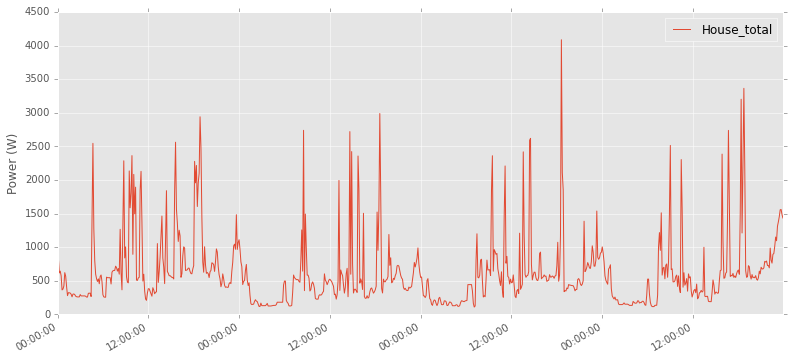

In [4]:
gjw.set_window('2015-06-01 00:00:00', '2015-06-05 00:00:00')
elec = gjw.buildings[building_number].elec
mains = elec.mains()
mains.plot()
#plt.show()

In [5]:
house = elec['fridge'] #only one meter so any selection will do
df = house.load().next() #load the first chunk of data into a dataframe
#df.info() #check that the data is what we want (optional)
#note the data has two columns and a time index


##Training##
We'll now do the training from the aggregate data. The algorithm segments the time series data into steady and transient states. Thus, we'll first figure out the transient and the steady states. Next, we'll try and pair the on and the off transitions based on their proximity in time and value.

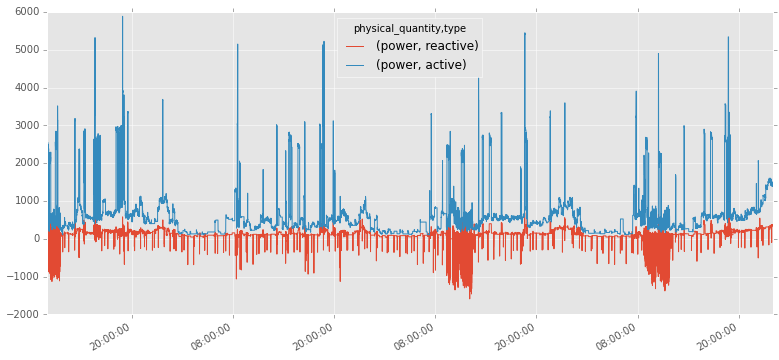

In [6]:
df.ix['2015-06-01 10:00:00+01:00':'2015-06-05 12:00:00+01:00'].plot()# select a time range and plot it
#plt.show()

In [7]:
h = Hart85()
h.train(mains,cols=[('power','active')])


Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Transition frame created.
Creating states frame ...
States frame created.
Finished.


In [8]:
h.steady_states.head()

,active average
2015-06-01 00:00:16+01:00,980.064706
2015-06-01 00:08:45+01:00,843.000000
2015-06-01 00:11:41+01:00,723.000000
2015-06-01 00:13:40+01:00,618.000000
2015-06-01 00:25:51+01:00,693.241935


In [9]:
h.steady_states.tail()

,active average
2015-06-04 23:22:44+01:00,1319
2015-06-04 23:34:17+01:00,1603
2015-06-04 23:42:13+01:00,1527
2015-06-04 23:47:46+01:00,1460
2015-06-04 23:59:54+01:00,1477


In [10]:
h.centroids

,"(power, active)"
0,174.816851
1,2095.918107
2,699.709904
3,1326.949720
4,2699.516843
5,1772.166667


In [11]:
h.model

{}

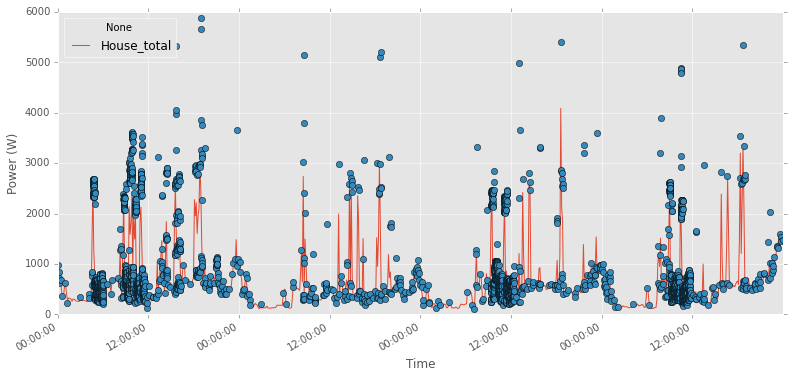

In [12]:
ax = mains.plot()
h.steady_states['active average'].plot(style='o', ax = ax);
plt.ylabel("Power (W)")
plt.xlabel("Time");
#plt.show()

In [23]:
h.pair_df.head()

,T1 Time,T1 Active,T2 Time,T2 Active
0,2015-05-31 23:56:25,237.027559,2015-06-01 00:15:51,-308.000000
1,2015-06-01 03:08:03,137.000000,2015-06-01 03:10:16,-79.002874
2,2015-06-01 02:01:21,77.000000,2015-06-01 03:35:32,-90.500000
3,2015-06-01 03:36:08,78.500000,2015-06-01 03:38:10,-72.000000
4,2015-06-01 03:35:14,267.000000,2015-06-01 03:38:59,-270.000000


In [51]:
pair_shape_df = pd.DataFrame(columns=['Height','Duration'])
pair_shape_df['Height']= (h.pair_df['T1 Active'].abs()+h.pair_df['T2 Active'].abs())/2
pair_shape_df['Duration']= pd.to_timedelta(h.pair_df['T2 Time']-h.pair_df['T1 Time'],unit='s').dt.seconds
pair_shape_df.head()

,Height,Duration
0,272.513780,1166
1,108.001437,133
2,83.750000,5651
3,75.250000,122
4,268.500000,225


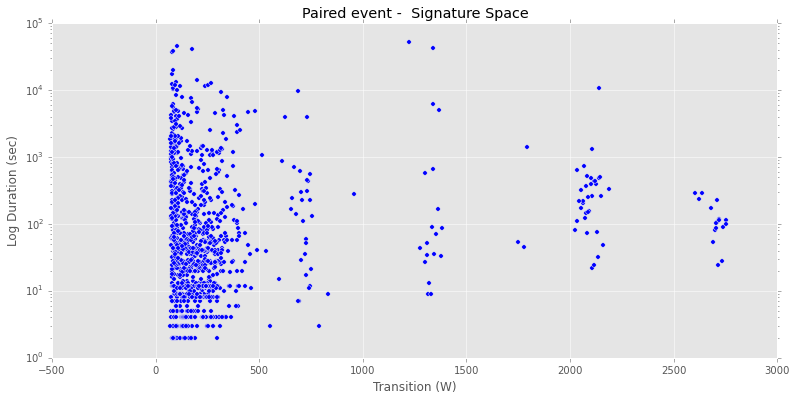

In [69]:
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(1, 1, 1)
ax.set_yscale('log')
ax.scatter(pair_shape_df['Height'],pair_shape_df['Duration'])
plt.title("Paired event -  Signature Space")
plt.ylabel("Log Duration (sec)")
plt.xlabel("Transition (W)");

##Set two days for Disaggregation period of interest##
Inspect the data during a quiet period when we were on holiday, should only be autonomous
appliances such as fidge, freeze and water heating + any standby devices not unplugged. 

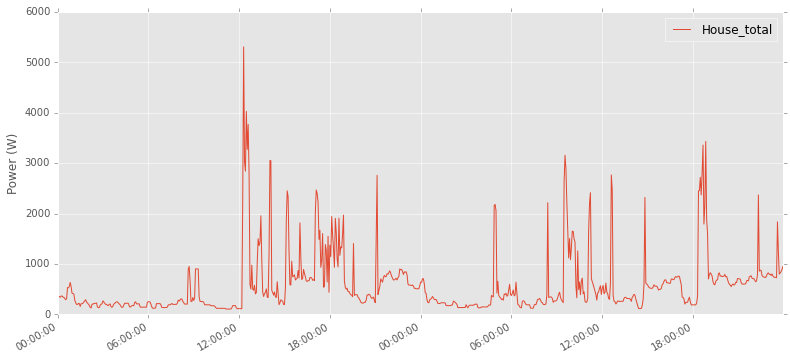

In [14]:
gjw.set_window('2015-06-08 00:00:00','2015-06-10 00:00:00')
elec = gjw.buildings[building_number].elec
mains = elec.mains()
mains.plot()


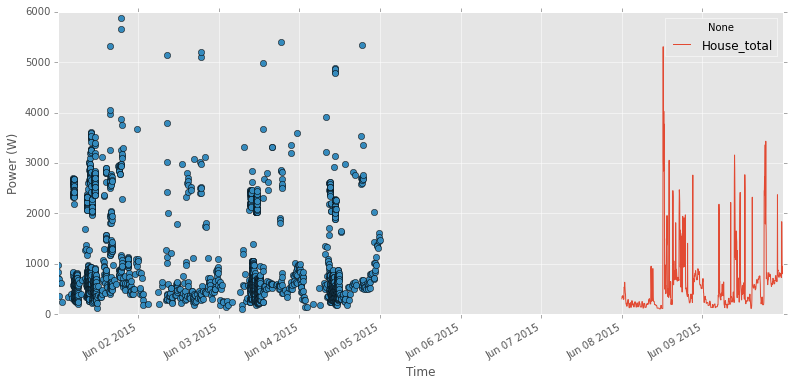

In [15]:
ax = mains.plot()
h.steady_states['active average'].plot(style='o', ax = ax);
plt.ylabel("Power (W)")
plt.xlabel("Time");

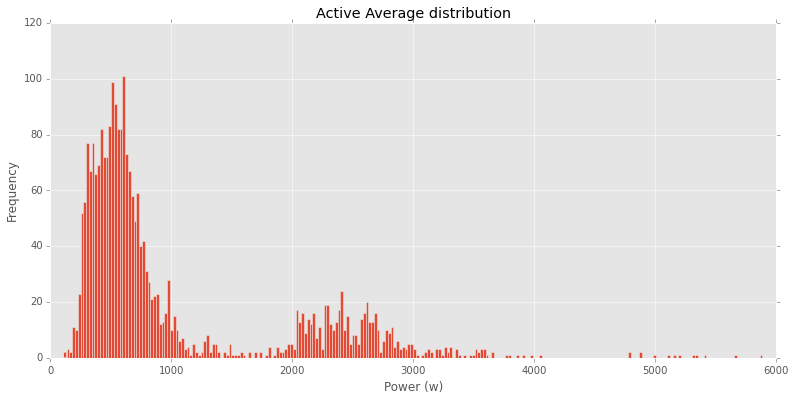

In [22]:
plt.hist(h.steady_states['active average'],250)
plt.ylabel("Frequency")
plt.xlabel("Power (w)")
plt.title("Active Average distribution");

##Disaggregate using Hart (Active data only)##

In [20]:
disag_filename = join(data_dir, 'disag_gjw_hart.hdf5')
output = HDFDataStore(disag_filename, 'w')
h.disaggregate(mains,output,sample_period=1)
output.close()

Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Transition frame created.
Creating states frame ...
States frame created.
Finished.


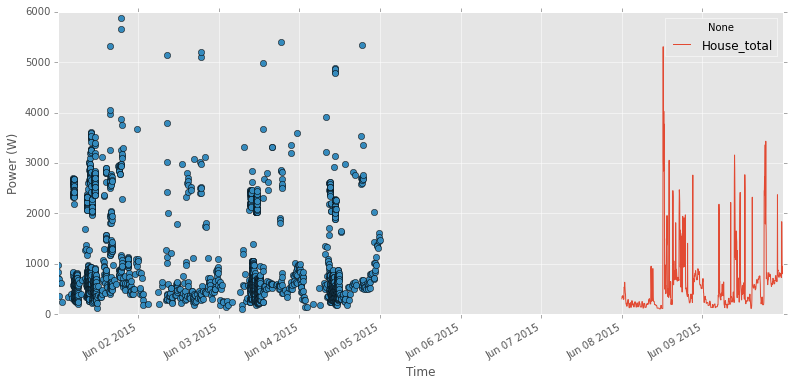

In [21]:
ax = mains.plot()
h.steady_states['active average'].plot(style='o', ax = ax);
plt.ylabel("Power (W)")
plt.xlabel("Time");

In [22]:
disag_hart = DataSet(disag_filename)
disag_hart

In [23]:
disag_hart_elec = disag_hart.buildings[building_number].elec
disag_hart_elec

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='Hart85_2015-10-08T15:53:54', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='Hart85_2015-10-08T15:53:54', appliances=[Appliance(type='unknown', instance=0)])
  ElecMeter(instance=3, building=1, dataset='Hart85_2015-10-08T15:53:54', appliances=[Appliance(type='unknown', instance=1)])
  ElecMeter(instance=4, building=1, dataset='Hart85_2015-10-08T15:53:54', appliances=[Appliance(type='unknown', instance=2)])
  ElecMeter(instance=5, building=1, dataset='Hart85_2015-10-08T15:53:54', appliances=[Appliance(type='unknown', instance=3)])
  ElecMeter(instance=6, building=1, dataset='Hart85_2015-10-08T15:53:54', appliances=[Appliance(type='unknown', instance=4)])
  ElecMeter(instance=7, building=1, dataset='Hart85_2015-10-08T15:53:54', appliances=[Appliance(type='unknown', instance=5)])
)

In [24]:
disag_hart_elec.mains()

ElecMeter(instance=1, building=1, dataset='Hart85_2015-10-08T15:53:54', site_meter, appliances=[])

In [25]:
h.centroids

,"(power, active)"
0,174.816851
1,2095.918107
2,699.709904
3,1326.949720
4,2699.516843
5,1772.166667


In [26]:
h.model

{}

In [27]:
h.steady_states

,active average
2015-06-01 00:00:16+01:00,980.064706
2015-06-01 00:08:45+01:00,843.000000
2015-06-01 00:11:41+01:00,723.000000
2015-06-01 00:13:40+01:00,618.000000
2015-06-01 00:25:51+01:00,693.241935
2015-06-01 00:33:35+01:00,365.000000
2015-06-01 00:56:25+01:00,622.027559
2015-06-01 01:15:51+01:00,236.000000
2015-06-01 03:01:21+01:00,338.000000
2015-06-01 04:08:03+01:00,396.000000


In [17]:
from nilmtk.metrics import f1_score
f1_hart= f1_score(disag_hart_elec, test_elec)
f1_hart.index = disag_hart_elec.get_labels(f1_hart.index)
f1_hart.plot(kind='barh')
plt.ylabel('appliance');
plt.xlabel('f-score');
plt.title("Hart");

NameError: name 'test_elec' is not defined